# Design 2-color mCherry smFISH

by Pu Zheng


In [1]:
# Basic imports
import os,sys,re
from importlib import reload
import numpy as np
import pandas as pd
#import torch
print(os.getpid())

1945572


In [2]:
# ChromAn related imports
sys.path.append(r'/lab/weissman_imaging/puzheng/Softwares/ChromAn') # parent folder of ChromAn
import src

## Master folder
folder storing all the libraries

In [3]:
library_master_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")

- FISH probe libraries stored in folder: /lab/solexa_weissman/puzheng/MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [4]:
reference_folder = r'/lab/solexa_weissman/puzheng/References/'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', '.DS_Store', 'Mus_musculus.GRCm39.cdna.all.fa', 'transcriptome_17.table', 'Mus_musculus.GRCm39.109.gff3']


# Define design parameters

## Folders

In [5]:
# Define the output files
library_folder = os.path.join(library_master_folder, 'smFISH', 'mCherry_v2')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry_v2
-- create library_folder: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry_v2
-- library savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry_v2/designed_probes.csv
-- library IDT format savefile: /lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry_v2/designed_probes_idt_oPool.xlsx


In [6]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'updated_Stvs.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [7]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [8]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
cdna = qc.check_and_standardize_transcriptome(cdna, remove_non_standard_columns=True)

ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file, None)
transcriptome = pd.concat([cdna, ], ignore_index=True)
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version



# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
CPU times: user 2.13 s, sys: 315 ms, total: 2.45 s
Wall time: 2.47 s


In [9]:
transcriptome

,transcript_id,sequence,FPKM,gene_id,gene_short_name
0,ENSMUST00000178537.2,GGGACAGGGGGC,1,ENSMUSG00000095668.2,Trbd1
1,ENSMUST00000178862.2,GGGACTGGGGGGGC,1,ENSMUSG00000094569.2,Trbd2
2,ENSMUST00000196221.2,ATGGCATAT,1,ENSMUSG00000096749.3,Trdd1
3,ENSMUST00000179664.2,ATGGCATATCA,1,ENSMUSG00000096749.3,Trdd1
4,ENSMUST00000177564.2,ATCGGAGGGATACGAG,1,ENSMUSG00000096176.2,Trdd2
...,...,...,...,...,...
116907,ENSMUST00000215557.2,ATGTAAAACCAGAGCTTTGTCACTGAGTTTCTACTGTGAGGCTTAT...,1,ENSMUSG00000111578.2,Gm18166
116908,ENSMUST00000215627.2,ATGTAAAACCAGAGCTTTGTCACTGAGTTTCTACTGTGAGGCTTAT...,1,ENSMUSG00000111460.2,None
116909,ENSMUST00000118137.2,ATGGATGAAGGCAATCACACTGTGGTGTCATAATTTACACTCTGGA...,1,ENSMUSG00000094074.2,None
116910,ENSMUST00000208680.2,AATAGGTCATCTAAGGCTCTGTCTACACTGACTGCTCATATCACAG...,1,ENSMUSG00000109287.2,Gm44713


In [10]:
# Let's have a look at the transcripts of the FLNA gene
transcriptome[transcriptome['gene_short_name'] == 'Cebpa'].sort_values('FPKM', ascending=False)

,transcript_id,sequence,FPKM,gene_id,gene_short_name
91805,ENSMUST00000205391.2,ATTCGCGACCCGAAGCTGCGCGGGCGCGAGCCAGTTGGGGCACTGG...,1,ENSMUSG00000034957.11,Cebpa
91806,ENSMUST00000042985.11,CGAAGCTGCGCGGGCGCGAGCCAGTTGGGGCACTGGGTGGGCGGCG...,1,ENSMUSG00000034957.11,Cebpa


## Add mCherry into transcriptome

In [11]:
# sequence directly copied from the vector
gene1_row = pd.Series(
    {'transcript_id':'artificialTranscript_mCherry_t1',
     'sequence': 'ATGGTGAGCAAGGGCGAGGAGGATAACATGGCCATCATCAAGGAGTTCATGCGCTTCAAGGTGCACATGGAGGGCTCCGTGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGCGGCCCCCTGCCCTTCGCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAAGGCCTACGTGAAGCACCCCGCCGACATCCCCGACTACTTGAAGCTGTCCTTCCCCGAGGGCTTCAAGTGGGAGCGCGTGATGAACTTCGAGGACGGCGGCGTGGTGACCGTGACCCAGGACTCCTCCCTGCAGGACGGCGAGTTCATCTACAAGGTGAAGCTGCGCGGCACCAACTTCCCCTCCGACGGCCCCGTAATGCAGAAGAAGACCATGGGCTGGGAGGCCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTAATGAA',
     'FPKM': 1,
     'gene_id':'artificialTranscript_mCherry',
     'gene_short_name': 'mCherry',
    }
)

In [12]:
transcriptome = pd.concat([transcriptome, gene1_row.to_frame().T], ignore_index=True)
transcriptome

,transcript_id,sequence,FPKM,gene_id,gene_short_name
0,ENSMUST00000178537.2,GGGACAGGGGGC,1,ENSMUSG00000095668.2,Trbd1
1,ENSMUST00000178862.2,GGGACTGGGGGGGC,1,ENSMUSG00000094569.2,Trbd2
2,ENSMUST00000196221.2,ATGGCATAT,1,ENSMUSG00000096749.3,Trdd1
3,ENSMUST00000179664.2,ATGGCATATCA,1,ENSMUSG00000096749.3,Trdd1
4,ENSMUST00000177564.2,ATCGGAGGGATACGAG,1,ENSMUSG00000096176.2,Trdd2
...,...,...,...,...,...
116908,ENSMUST00000215627.2,ATGTAAAACCAGAGCTTTGTCACTGAGTTTCTACTGTGAGGCTTAT...,1,ENSMUSG00000111460.2,None
116909,ENSMUST00000118137.2,ATGGATGAAGGCAATCACACTGTGGTGTCATAATTTACACTCTGGA...,1,ENSMUSG00000094074.2,None
116910,ENSMUST00000208680.2,AATAGGTCATCTAAGGCTCTGTCTACACTGACTGCTCATATCACAG...,1,ENSMUSG00000109287.2,Gm44713
116911,ENSMUST00000208550.2,ATGGATAAAAGAGAATCACTCTATTGTGTCTGAGTTTGTGTTCTTG...,1,ENSMUSG00000109522.2,None


## Select genes

In [13]:
sel_genes = ['mCherry']

### based on genes, select 2-color readouts

In [14]:
readout_df = fio.load_fasta_into_df(readout_fasta_file)
readout_names = list(readout_df['id'])

start_bit = 8
num_on_bits = 4

bit_names = readout_names[start_bit:start_bit+num_on_bits*len(sel_genes)]
readout_seqs = readout_df['sequence'][start_bit:start_bit+num_on_bits*len(sel_genes)]
print(bit_names)

['Stv_11', 'Stv_12', 'Stv_13', 'Stv_14']


### design 4-color barcode table

In [15]:
barcodes = []
for _i, _name in enumerate(sel_genes):
    _base_str = np.zeros(num_on_bits*len(sel_genes), dtype=np.int32)
    _base_str[num_on_bits*_i:num_on_bits*_i+num_on_bits] = 1
    barcodes.append(''.join(_base_str.astype(str)))
print(barcodes)

['1111']


### combine

In [16]:
barcode_table = pd.DataFrame({'name':sel_genes, 
                              #'id':['ENSMUSG00000061527.8', 'ENSMUSG00000000731.16'], 
                              #'id':['ENSMUST00000023709.7', 'ENSMUST00000145975.8'], 
                              'barcode_str':barcodes})
barcode_table

,name,barcode_str
0,mCherry,1111


## Initialize probe dict

In [17]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(sel_genes, transcriptome, 
                                 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

Found 1 transcripts for 1 target genes.
Gene	Transcript	N_probes
mCherry
	artificialTranscript_mCherry_t1	686


## Calculate and filter by probe GC

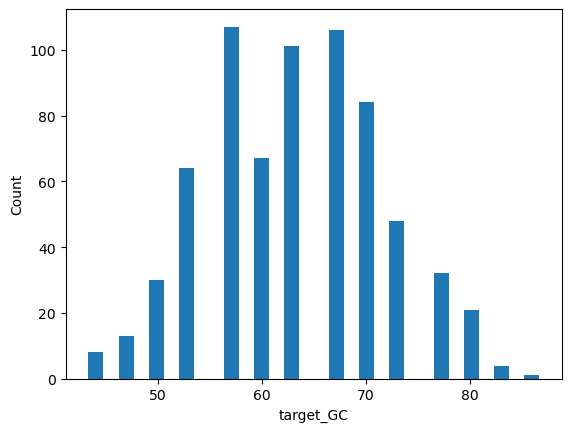

In [18]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

mCherry
	artificialTranscript_mCherry_t1: 496 / 686 probes passed the filter 40 < target_GC <  70.


/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


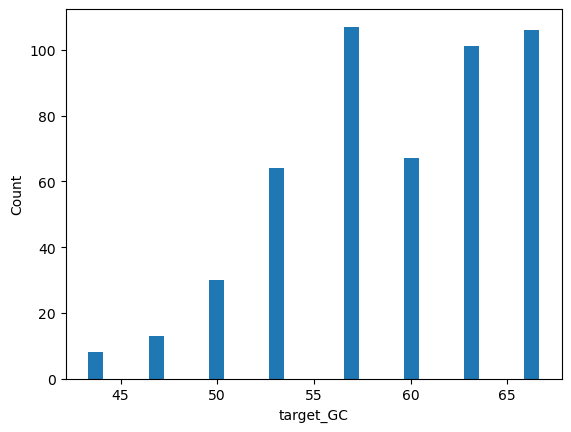

In [19]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

## Calculate and filter by probe Tm

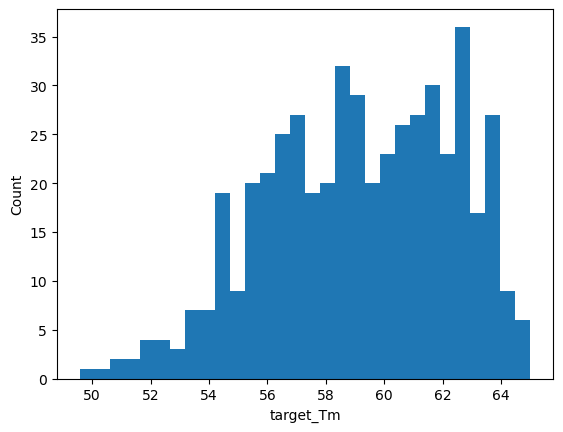

In [20]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

mCherry
	artificialTranscript_mCherry_t1: 484 / 496 probes passed the filter 52 < target_Tm <  65.


/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


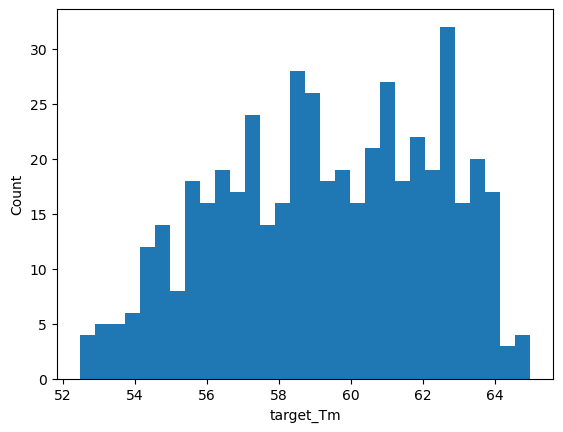

In [21]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=52, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

## Calculate off-targets

### Generate CountTable

In [22]:
# Initialize the off-target counting tables
overwrite_ottable = True
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [23]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_genes, 'gene_short_name', 17)

Generate OTTable for gene mCherry.
Construct a OTTable using 1/1 transcripts with FPKM > 0.


In [24]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 116913/116913 transcripts with FPKM > 0.
Processed 10000/116913 sequences.
Processed 20000/116913 sequences.
Processed 30000/116913 sequences.
Processed 40000/116913 sequences.
Processed 50000/116913 sequences.
Processed 60000/116913 sequences.
Processed 70000/116913 sequences.
Processed 80000/116913 sequences.
Processed 90000/116913 sequences.
Processed 100000/116913 sequences.
Processed 110000/116913 sequences.


### Off-targets to rRNA/tRNAs

In [25]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/1 genes.
mCherry
	artificialTranscript_mCherry_t1: 484 / 484 probes passed the filter -inf < target_OT_rtRNA <  0.5.


/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


### Off-targets to transcriptome

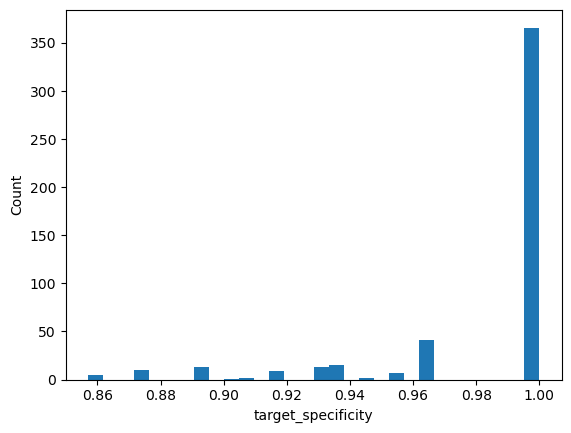

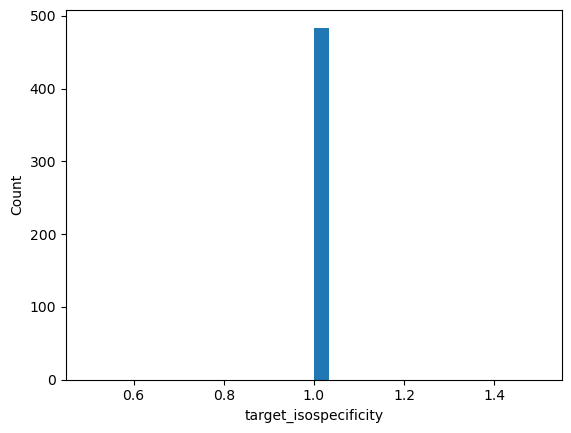

In [26]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [27]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

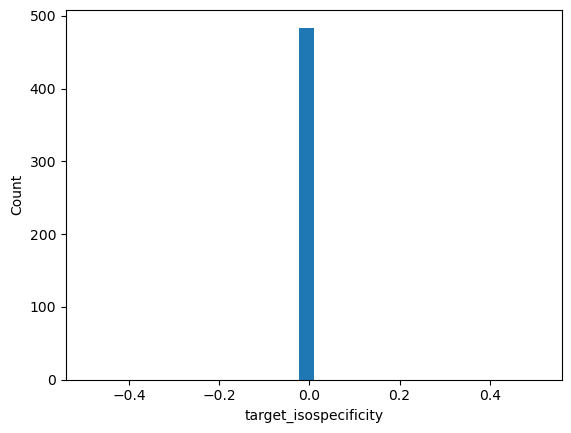

In [28]:
plot.plot_hist(probe_dict, 'target_isospecificity')

mCherry
	artificialTranscript_mCherry_t1: 366 / 484 probes passed the filter 0.99 < target_specificity <  inf.


/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


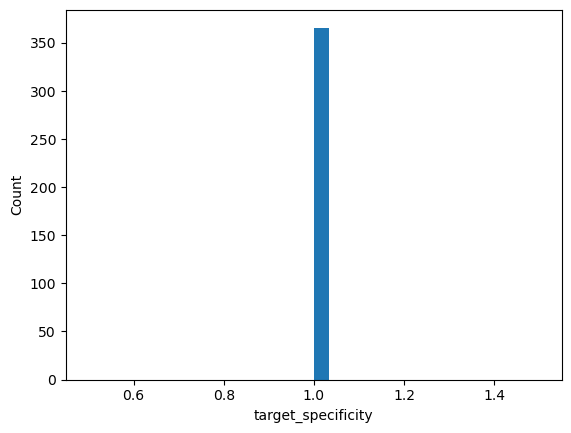

In [29]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

mCherry
	artificialTranscript_mCherry_t1: 366 / 366 probes passed the filter 0.0 < target_isospecificity <  0.66.


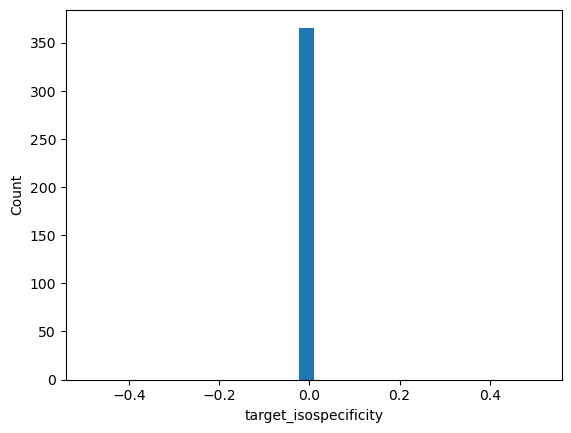

In [30]:
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_isospecificity', 
                                    lower_bound=0., upper_bound=0.66)
plot.plot_hist(probe_dict, 'target_isospecificity')

## Select the transcript with the most probes

In [31]:
select_transcripts = True
if select_transcripts:
    # Manual selection
    #probe_dict = p_d.select_transcripts_by_ids(probe_dict, transcript_ids=['ENSMUST00000003100.10', ])
    
    # Select the transcript with most probes passed QC:
    probe_dict = p_d.select_transcripts_by_num_probes(probe_dict)
    p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
mCherry
	artificialTranscript_mCherry_t1	366


# Add readouts

In [32]:
# Load readouts
readout_seqs = readout_seqs = readout_df[start_bit:start_bit+num_on_bits*len(sel_genes)]
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)
readout_seqs

/lab/weissman_imaging/puzheng/Softwares/MERFISH_probe_design/MERFISH_probe_design/probe_design/readout_sequences.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readout_seqs['on-bit'] = pd.Series(on_bits, index=readout_seqs.index)


,id,description,sequence,on-bit
8,Stv_11,Stv_11 old_barcode,GGCCAATGGCCCAGGTCCGTCACGCAATTT,0
9,Stv_12,Stv_12 old_barcode,TTGATCGAATCGGAGCGTAGCGGAATCTGC,1
10,Stv_13,Stv_13 old_barcode,CGCGCGGATCCGCTTGTCGGGAACGGATAC,2
11,Stv_14,Stv_14 old_barcode,GCCTCGATTACGACGGATGTAATTCGGCCG,3


In [33]:
# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
num_readout_per_probe = 3
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 
                                     num_readout_per_probe, 
                                     spacer='A', gene_id_key='name', 
                                     each_probe_1_on_bit=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
19
23
24
25
26
41
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
86
124
125
126
127
128
129
130
131
132
133
134
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
218
219
220
221
222
223
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
323
324
341
342
343
344
345
346
347
348
349
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
470
471
472
473
474
475
476
477
478
479
480
481
482
483
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
5

In [34]:
probe_dict['mCherry']['artificialTranscript_mCherry_t1']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence
0,mCherry,artificialTranscript_mCherry_t1,0,ATGGTGAGCAAGGGCGAGGAGGATAACATG,53.333333,56.614913,0,1.0,0.01,Stv_13::Stv_14:Stv_12,0111,CGCGCGGATCCGCTTGTCGGGAACGGATACAATGGTGAGCAAGGGC...
1,mCherry,artificialTranscript_mCherry_t1,1,TGGTGAGCAAGGGCGAGGAGGATAACATGG,56.666667,58.533801,0,1.0,0.01,Stv_12::Stv_11:Stv_14,1101,TTGATCGAATCGGAGCGTAGCGGAATCTGCATGGTGAGCAAGGGCG...
2,mCherry,artificialTranscript_mCherry_t1,2,GGTGAGCAAGGGCGAGGAGGATAACATGGC,60.000000,59.239077,0,1.0,0.01,Stv_13::Stv_12:Stv_14,0111,CGCGCGGATCCGCTTGTCGGGAACGGATACAGGTGAGCAAGGGCGA...
3,mCherry,artificialTranscript_mCherry_t1,3,GTGAGCAAGGGCGAGGAGGATAACATGGCC,60.000000,59.239077,0,1.0,0.01,Stv_11::Stv_12:Stv_14,1101,GGCCAATGGCCCAGGTCCGTCACGCAATTTAGTGAGCAAGGGCGAG...
4,mCherry,artificialTranscript_mCherry_t1,4,TGAGCAAGGGCGAGGAGGATAACATGGCCA,56.666667,59.914667,0,1.0,0.01,Stv_11::Stv_14:Stv_12,1101,GGCCAATGGCCCAGGTCCGTCACGCAATTTATGAGCAAGGGCGAGG...
...,...,...,...,...,...,...,...,...,...,...,...,...
681,mCherry,artificialTranscript_mCherry_t1,681,ACCGGCGGCATGGACGAGCTGTACAAGTAA,56.666667,59.606651,0,1.0,0.01,Stv_14::Stv_11:Stv_12,1101,GCCTCGATTACGACGGATGTAATTCGGCCGAACCGGCGGCATGGAC...
682,mCherry,artificialTranscript_mCherry_t1,682,CCGGCGGCATGGACGAGCTGTACAAGTAAT,56.666667,58.553826,0,1.0,0.01,Stv_12::Stv_11:Stv_13,1110,TTGATCGAATCGGAGCGTAGCGGAATCTGCACCGGCGGCATGGACG...
683,mCherry,artificialTranscript_mCherry_t1,683,CGGCGGCATGGACGAGCTGTACAAGTAATG,56.666667,57.093215,0,1.0,0.01,Stv_12::Stv_14:Stv_13,0111,TTGATCGAATCGGAGCGTAGCGGAATCTGCACGGCGGCATGGACGA...
684,mCherry,artificialTranscript_mCherry_t1,684,GGCGGCATGGACGAGCTGTACAAGTAATGA,53.333333,56.456810,0,1.0,0.01,Stv_13::Stv_12:Stv_11,1110,CGCGCGGATCCGCTTGTCGGGAACGGATACAGGCGGCATGGACGAG...


In [35]:
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=72, N_on_bits=num_on_bits)

mCherry:artificialTranscript_mCherry_t1: selected 72/366 probes with N_overlapping_bases=2652.0 and on-bit_coverage={0: 55, 1: 54, 2: 54, 3: 53}.


# Primer design

In [36]:
# Load the primer candidates into data frames
forward_primers, reverse_primers = fio.load_primers(forward_primer_file, reverse_primer_file)
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG


,id,description,sequence,sequence_rc
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA


In [37]:
# Selet primers
# Make an off-target from the current probe sequences.
ottable_target_readout = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15)

# Calculate the off-targets for the primer sequences and their reverse-complements
# Usually, there shouln't be any off-targets
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
# Display primer OT tables to manually select
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG,0,0
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG,0,0
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA,0,0
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA,0,0
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA,0,0
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC,0,0
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG,0,0
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG,0,0


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA,0,0
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA,0,0
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA,0,0
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA,0,0
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA,0,0
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA,0,0
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA,0,0


In [38]:
forward_primers = pd.DataFrame(forward_primers.loc[forward_primers['id']=='W1A03_primer_2'],)
reverse_primers = pd.DataFrame(reverse_primers[reverse_primers['id']=='W1A10_primer_9'], index=None)

In [39]:
# Add the primer sequences

# NOTE: the sequence after primer addition should be (reverse_primer)-(target_readouts)-(forward_primer_rc)
primer_design.add_primer_sequences(probe_dict, 
                                   reverse_primers.iloc[0]['sequence'][-20:], 
                                   forward_primers.iloc[0]['sequence_rc'], ## In this case don't add forward primers at all
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence')

# Notice that the T7 promoter (the first 17 bases of the reverse primer) will be lost after in vitro transcription
# create a column of the T7 transcribed sequences for the subsequent quality check
primer_design.add_primer_sequences(probe_dict, 
                reverse_primers.iloc[0]['sequence'][17:], forward_primers.iloc[0]['sequence_rc'],
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence_t7_transcribed')

In [40]:
print(selected_primers_file)
merged_primer_df = pd.concat([forward_primers, reverse_primers], ignore_index=True)
merged_primer_df.to_csv(selected_primers_file)
merged_primer_df

/lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry_v2/selected_primers.csv


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
1,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0


# Quality check

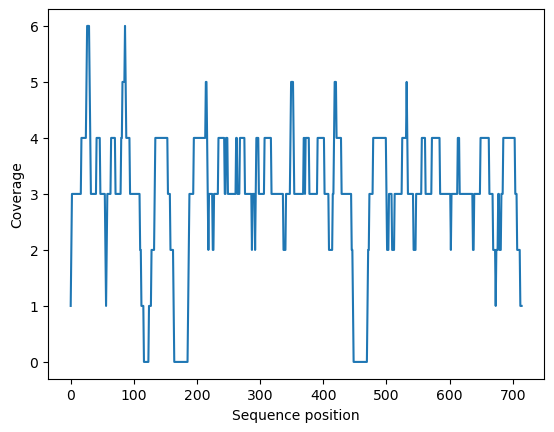

In [41]:
# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'artificialTranscript_mCherry_t1'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['mCherry']['artificialTranscript_mCherry_t1'], seq_len)

Calculate OTs for 0/1 genes.


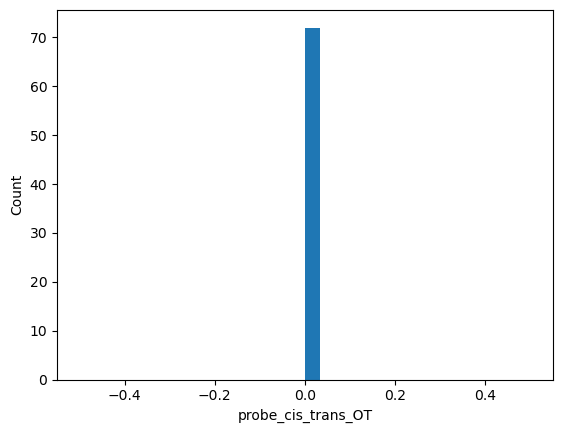

In [42]:
# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')

# Output

## Default csv output

In [45]:
probe_dict['mCherry']['artificialTranscript_mCherry_t1']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_primer_sequence,target_readout_primer_sequence_t7_transcribed,probe_cis_trans_OT
64,mCherry,artificialTranscript_mCherry_t1,64,ACATGGAGGGCTCCGTGAACGGCCACGAGT,63.333333,62.610130,0,1.0,0.01,Stv_12::Stv_13:Stv_11,1110,TTGATCGAATCGGAGCGTAGCGGAATCTGCAACATGGAGGGCTCCG...,GGATTGCCGCATGGTTTCCGTTGATCGAATCGGAGCGTAGCGGAAT...,GGGATTGCCGCATGGTTTCCGTTGATCGAATCGGAGCGTAGCGGAA...,0
124,mCherry,artificialTranscript_mCherry_t1,124,CCTACGAGGGCACCCAGACCGCCAAGCTGA,66.666667,63.604629,0,1.0,0.01,Stv_13::Stv_12:Stv_14,0111,CGCGCGGATCCGCTTGTCGGGAACGGATACACCTACGAGGGCACCC...,GGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACGG...,GGGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACG...,0
607,mCherry,artificialTranscript_mCherry_t1,607,AGTTGGACATCACCTCCCACAACGAGGACT,53.333333,56.886235,0,1.0,0.01,Stv_14::Stv_12:Stv_11,1101,GCCTCGATTACGACGGATGTAATTCGGCCGAAGTTGGACATCACCT...,GGATTGCCGCATGGTTTCCGGCCTCGATTACGACGGATGTAATTCG...,GGGATTGCCGCATGGTTTCCGGCCTCGATTACGACGGATGTAATTC...,0
294,mCherry,artificialTranscript_mCherry_t1,294,GAGCGCGTGATGAACTTCGAGGACGGCGGC,66.666667,60.918066,0,1.0,0.01,Stv_11::Stv_13:Stv_14,1011,GGCCAATGGCCCAGGTCCGTCACGCAATTTAGAGCGCGTGATGAAC...,GGATTGCCGCATGGTTTCCGGGCCAATGGCCCAGGTCCGTCACGCA...,GGGATTGCCGCATGGTTTCCGGGCCAATGGCCCAGGTCCGTCACGC...,0
572,mCherry,artificialTranscript_mCherry_t1,572,CGTGCAGCTGCCCGGCGCCTACAACGTCAA,66.666667,63.556580,0,1.0,0.01,Stv_12::Stv_13:Stv_11,1110,TTGATCGAATCGGAGCGTAGCGGAATCTGCACGTGCAGCTGCCCGG...,GGATTGCCGCATGGTTTCCGTTGATCGAATCGGAGCGTAGCGGAAT...,GGGATTGCCGCATGGTTTCCGTTGATCGAATCGGAGCGTAGCGGAA...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,mCherry,artificialTranscript_mCherry_t1,556,ACAAGGCCAAGAAGCCCGTGCAGCTGCCCG,66.666667,64.311837,0,1.0,0.01,Stv_11::Stv_12:Stv_13,1110,GGCCAATGGCCCAGGTCCGTCACGCAATTTAACAAGGCCAAGAAGC...,GGATTGCCGCATGGTTTCCGGGCCAATGGCCCAGGTCCGTCACGCA...,GGGATTGCCGCATGGTTTCCGGGCCAATGGCCCAGGTCCGTCACGC...,0
471,mCherry,artificialTranscript_mCherry_t1,471,GAGGACGGCGCCCTGAAGGGCGAGATCAAG,66.666667,61.637884,0,1.0,0.01,Stv_12::Stv_11:Stv_14,1101,TTGATCGAATCGGAGCGTAGCGGAATCTGCAGAGGACGGCGCCCTG...,GGATTGCCGCATGGTTTCCGTTGATCGAATCGGAGCGTAGCGGAAT...,GGGATTGCCGCATGGTTTCCGTTGATCGAATCGGAGCGTAGCGGAA...,0
58,mCherry,artificialTranscript_mCherry_t1,58,AGGTGCACATGGAGGGCTCCGTGAACGGCC,66.666667,63.891521,0,1.0,0.01,Stv_13::Stv_12:Stv_11,1110,CGCGCGGATCCGCTTGTCGGGAACGGATACAAGGTGCACATGGAGG...,GGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACGG...,GGGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACG...,0
188,mCherry,artificialTranscript_mCherry_t1,188,GGACATCCTGTCCCCTCAGTTCATGTACGG,56.666667,56.722448,0,1.0,0.01,Stv_14::Stv_13:Stv_11,1011,GCCTCGATTACGACGGATGTAATTCGGCCGAGGACATCCTGTCCCC...,GGATTGCCGCATGGTTTCCGGCCTCGATTACGACGGATGTAATTCG...,GGGATTGCCGCATGGTTTCCGGCCTCGATTACGACGGATGTAATTC...,0


In [46]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(probe_dict, 'target_readout_primer_sequence', 'target_readout_primer_sequence_rc')
p_d.get_rc_sequences(probe_dict, 'target_readout_sequence', 'target_readout_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(probe_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
print(probe_output_file)
df_all_probes.to_csv(probe_output_file, index=False)

/lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry_v2/designed_probes.csv


## IDT oPool version output

In [48]:
# calculate gene_2_bits
gene_2_bits = {}
for _gene in np.unique(df_all_probes['gene_id']):
    _readouts = np.unique([_n.split(':')
                           for _n in np.unique(df_all_probes.loc[df_all_probes['gene_id']==_gene, 'readout_names'])])
    _readouts = [_r for _r in _readouts if len(_r)]
    print(_gene, _readouts)
    gene_2_bits[_gene] = _readouts

mCherry ['Stv_11', 'Stv_12', 'Stv_13', 'Stv_14']


In [49]:
df_all_probes

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_primer_sequence,target_readout_primer_sequence_t7_transcribed,probe_cis_trans_OT,target_readout_primer_sequence_rc,target_readout_sequence_rc,probe_names
0,mCherry,artificialTranscript_mCherry_t1,0,ATGGTGAGCAAGGGCGAGGAGGATAACATG,53.333333,56.614913,0,1.0,0.01,Stv_13::Stv_14:Stv_12,0111,CGCGCGGATCCGCTTGTCGGGAACGGATACAATGGTGAGCAAGGGC...,GGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACGG...,GGGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACG...,0,CCCGCAATGGCTGACAACCGGCAGATTCCGCTACGCTCCGATTCGA...,GCAGATTCCGCTACGCTCCGATTCGATCAATCGGCCGAATTACATC...,mCherry_artificialTranscript_mCherry_t1_shift:...
2,mCherry,artificialTranscript_mCherry_t1,2,GGTGAGCAAGGGCGAGGAGGATAACATGGC,60.000000,59.239077,0,1.0,0.01,Stv_13::Stv_12:Stv_14,0111,CGCGCGGATCCGCTTGTCGGGAACGGATACAGGTGAGCAAGGGCGA...,GGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACGG...,GGGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACG...,0,CCCGCAATGGCTGACAACCGCGGCCGAATTACATCCGTCGTAATCG...,CGGCCGAATTACATCCGTCGTAATCGAGGCTGCAGATTCCGCTACG...,mCherry_artificialTranscript_mCherry_t1_shift:...
57,mCherry,artificialTranscript_mCherry_t1,57,AAGGTGCACATGGAGGGCTCCGTGAACGGC,63.333333,62.108162,0,1.0,0.01,Stv_14::Stv_13:Stv_12,0111,GCCTCGATTACGACGGATGTAATTCGGCCGAAAGGTGCACATGGAG...,GGATTGCCGCATGGTTTCCGGCCTCGATTACGACGGATGTAATTCG...,GGGATTGCCGCATGGTTTCCGGCCTCGATTACGACGGATGTAATTC...,0,CCCGCAATGGCTGACAACCGGCAGATTCCGCTACGCTCCGATTCGA...,GCAGATTCCGCTACGCTCCGATTCGATCAATGTATCCGTTCCCGAC...,mCherry_artificialTranscript_mCherry_t1_shift:...
124,mCherry,artificialTranscript_mCherry_t1,124,CCTACGAGGGCACCCAGACCGCCAAGCTGA,66.666667,63.604629,0,1.0,0.01,Stv_13::Stv_12:Stv_14,0111,CGCGCGGATCCGCTTGTCGGGAACGGATACACCTACGAGGGCACCC...,GGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACGG...,GGGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACG...,0,CCCGCAATGGCTGACAACCGCGGCCGAATTACATCCGTCGTAATCG...,CGGCCGAATTACATCCGTCGTAATCGAGGCTGCAGATTCCGCTACG...,mCherry_artificialTranscript_mCherry_t1_shift:...
134,mCherry,artificialTranscript_mCherry_t1,134,CACCCAGACCGCCAAGCTGAAGGTGACCAA,60.000000,60.311319,0,1.0,0.01,Stv_14::Stv_12:Stv_13,0111,GCCTCGATTACGACGGATGTAATTCGGCCGACACCCAGACCGCCAA...,GGATTGCCGCATGGTTTCCGGCCTCGATTACGACGGATGTAATTCG...,GGGATTGCCGCATGGTTTCCGGCCTCGATTACGACGGATGTAATTC...,0,CCCGCAATGGCTGACAACCGGTATCCGTTCCCGACAAGCGGATCCG...,GTATCCGTTCCCGACAAGCGGATCCGCGCGTGCAGATTCCGCTACG...,mCherry_artificialTranscript_mCherry_t1_shift:...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,mCherry,artificialTranscript_mCherry_t1,556,ACAAGGCCAAGAAGCCCGTGCAGCTGCCCG,66.666667,64.311837,0,1.0,0.01,Stv_11::Stv_12:Stv_13,1110,GGCCAATGGCCCAGGTCCGTCACGCAATTTAACAAGGCCAAGAAGC...,GGATTGCCGCATGGTTTCCGGGCCAATGGCCCAGGTCCGTCACGCA...,GGGATTGCCGCATGGTTTCCGGGCCAATGGCCCAGGTCCGTCACGC...,0,CCCGCAATGGCTGACAACCGGTATCCGTTCCCGACAAGCGGATCCG...,GTATCCGTTCCCGACAAGCGGATCCGCGCGTGCAGATTCCGCTACG...,mCherry_artificialTranscript_mCherry_t1_shift:...
572,mCherry,artificialTranscript_mCherry_t1,572,CGTGCAGCTGCCCGGCGCCTACAACGTCAA,66.666667,63.556580,0,1.0,0.01,Stv_12::Stv_13:Stv_11,1110,TTGATCGAATCGGAGCGTAGCGGAATCTGCACGTGCAGCTGCCCGG...,GGATTGCCGCATGGTTTCCGTTGATCGAATCGGAGCGTAGCGGAAT...,GGGATTGCCGCATGGTTTCCGTTGATCGAATCGGAGCGTAGCGGAA...,0,CCCGCAATGGCTGACAACCGAAATTGCGTGACGGACCTGGGCCATT...,AAATTGCGTGACGGACCTGGGCCATTGGCCTGTATCCGTTCCCGAC...,mCherry_artificialTranscript_mCherry_t1_shift:...
677,mCherry,artificialTranscript_mCherry_t1,677,CTCCACCGGCGGCATGGACGAGCTGTACAA,63.333333,61.544496,0,1.0,0.01,Stv_13::Stv_11:Stv_12,1110,CGCGCGGATCCGCTTGTCGGGAACGGATACACTCCACCGGCGGCAT...,GGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACGG...,GGGATTGCCGCATGGTTTCCGCGCGCGGATCCGCTTGTCGGGAACG...,0,CCCGCAATGGCTGACAACCGGCAGATTCCGCTACGCTCCGATTCGA...,GCAGATTCCGCTACGCTCCGATTCGATCAATAAATTGCGTGACGGA...,mCherry_artificialTranscript_mCherry_t1_shift:...
682,mCherry,artificialTranscript_mCherry_t1,682,CCGGCGGCATGGACGAGCTGTACAAGTAAT,

In [50]:
df_idt_probes = {'Pool name':[], 'Sequence':[]}
for _gene, _seq in zip(df_all_probes['gene_id'], df_all_probes['target_readout_sequence_rc']):
    df_idt_probes['Pool name'].append(f"smFISH_{_gene}_"+str(gene_2_bits[_gene]).replace('\'','').replace(' ','').replace('Bit-','b'))
    #df_idt_probes['Pool name'].append('smFISH_LungCancerTest1')
    df_idt_probes['Sequence'].append(_seq)
df_idt_probes = pd.DataFrame(df_idt_probes)
df_idt_probes

,Pool name,Sequence
0,"smFISH_mCherry_[Stv_11,Stv_12,Stv_13,Stv_14]",GCAGATTCCGCTACGCTCCGATTCGATCAATCGGCCGAATTACATC...
1,"smFISH_mCherry_[Stv_11,Stv_12,Stv_13,Stv_14]",CGGCCGAATTACATCCGTCGTAATCGAGGCTGCAGATTCCGCTACG...
2,"smFISH_mCherry_[Stv_11,Stv_12,Stv_13,Stv_14]",GCAGATTCCGCTACGCTCCGATTCGATCAATGTATCCGTTCCCGAC...
3,"smFISH_mCherry_[Stv_11,Stv_12,Stv_13,Stv_14]",CGGCCGAATTACATCCGTCGTAATCGAGGCTGCAGATTCCGCTACG...
4,"smFISH_mCherry_[Stv_11,Stv_12,Stv_13,Stv_14]",GTATCCGTTCCCGACAAGCGGATCCGCGCGTGCAGATTCCGCTACG...
...,...,...
67,"smFISH_mCherry_[Stv_11,Stv_12,Stv_13,Stv_14]",GTATCCGTTCCCGACAAGCGGATCCGCGCGTGCAGATTCCGCTACG...
68,"smFISH_mCherry_[Stv_11,Stv_12,Stv_13,Stv_14]",AAATTGCGTGACGGACCTGGGCCATTGGCCTGTATCCGTTCCCGAC...
69,"smFISH_mCherry_[Stv_11,Stv_12,Stv_13,Stv_14]",GCAGATTCCGCTACGCTCCGATTCGATCAATAAATTGCGTGACGGA...
70,"smFISH_mCherry_[Stv_11,Stv_12,Stv_13,Stv_14]",GTATCCGTTCCCGACAAGCGGATCCGCGCGTAAATTGCGTGACGGA...


In [51]:
# Write the designed probes
print(probe_output_idt_file)
df_idt_probes.to_excel(probe_output_idt_file, index=False)

/lab/solexa_weissman/puzheng/MERFISH_Probes/smFISH/mCherry_v2/designed_probes_idt_oPool.xlsx


In [52]:
df_idt_probes['Sequence'][0]

'GCAGATTCCGCTACGCTCCGATTCGATCAATCGGCCGAATTACATCCGTCGTAATCGAGGCTCATGTTATCCTCCTCGCCCTTGCTCACCATTGTATCCGTTCCCGACAAGCGGATCCGCGCG'

In [53]:
df_idt_probes['Sequence'][0][20:40]

'ATTCGATCAATCGGCCGAAT'

## Test the sequence direction

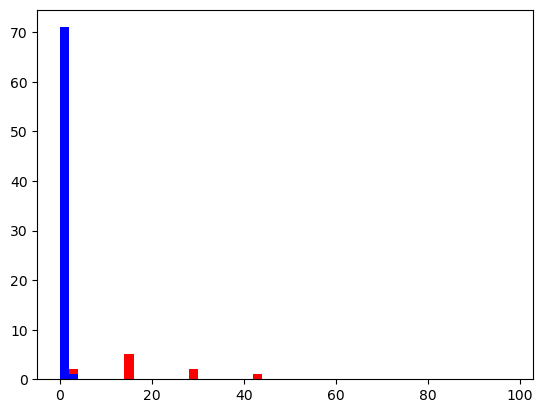

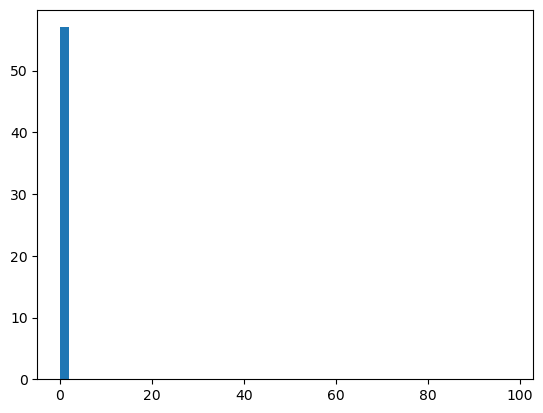

In [54]:
from Bio.Seq import reverse_complement
import matplotlib.pyplot as plt

ct_list, rc_ct_list = [], []

for _probe_seq in df_idt_probes['Sequence']:
    _target_seq = _probe_seq[40:70]
    _target_rc_seq = reverse_complement(_target_seq)
    _ct, _rc_ct = 0, 0
    for _i in range(0,30-17+1):
        _ct += ottable_transcriptome[_target_seq[_i:_i+17]]
        _rc_ct += ottable_transcriptome[_target_rc_seq[_i:_i+17]]
    #print(_ct, _rc_ct)
    ct_list.append(_ct)
    rc_ct_list.append(_rc_ct)
    
plt.figure()
plt.hist(ct_list, bins=np.arange(0,100,2), color='red')
plt.hist(rc_ct_list, bins=np.arange(0,100,2), color='blue')
plt.show()
plt.figure()
plt.hist(np.array(rc_ct_list) - np.array(ct_list), bins=np.arange(0,100,2))
plt.show()